In [27]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpubr)
require(pbapply)
pboptions(type="timer")

In [2]:
nthreads=10

# Quality of spot calling

In [3]:
thresholds = c(seq(0, .1, by=.01), seq(.2, 1, by=.1), seq(2, 50))

In [4]:
threshold_strings = sprintf("%05.2f", thresholds)

In [5]:
dw__root = "../data/single_FoV_different_thresholds/data/dw/"
raw_root = "../data/single_FoV_different_thresholds/data/raw/"

In [6]:
dw__data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(dw__root, sprintf("new_decoded_human_cortex_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "dw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


In [7]:
raw_data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(raw_root, sprintf("new_decoded_human_cortex_before_deconvolution_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "raw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  


In [8]:
ddata = rbindlist(list(dw__data, raw_data))

In [9]:
ddata[, V1 := NULL]

In [10]:
colnames(ddata)

[1] "intensity"         "z"                 "y"                
 [4] "x"                 "radius"            "spot_id"          
 [7] "z_min"             "z_max"             "y_min"            
[10] "y_max"             "x_min"             "x_max"            
[13] "features"          "xc"                "yc"               
[16] "zc"                "target"            "distance"         
[19] "passes_thresholds" "FOV"               "QC_score"         
[22] "thr"               "image_type"

In [11]:
ddata[, target_assigned := "unassigned"]
ddata['nan' != target, target_assigned := "assigned"]

In [12]:
qc_data = ddata["assigned" == target_assigned, .(
    QC_min=min(QC_score), QC_mean=mean(QC_score), QC_median=median(QC_score), QC_max=max(QC_score)
), by=c("image_type", "thr")]

In [13]:
pdata_qc = melt(qc_data, id.vars=c("image_type", "thr"))

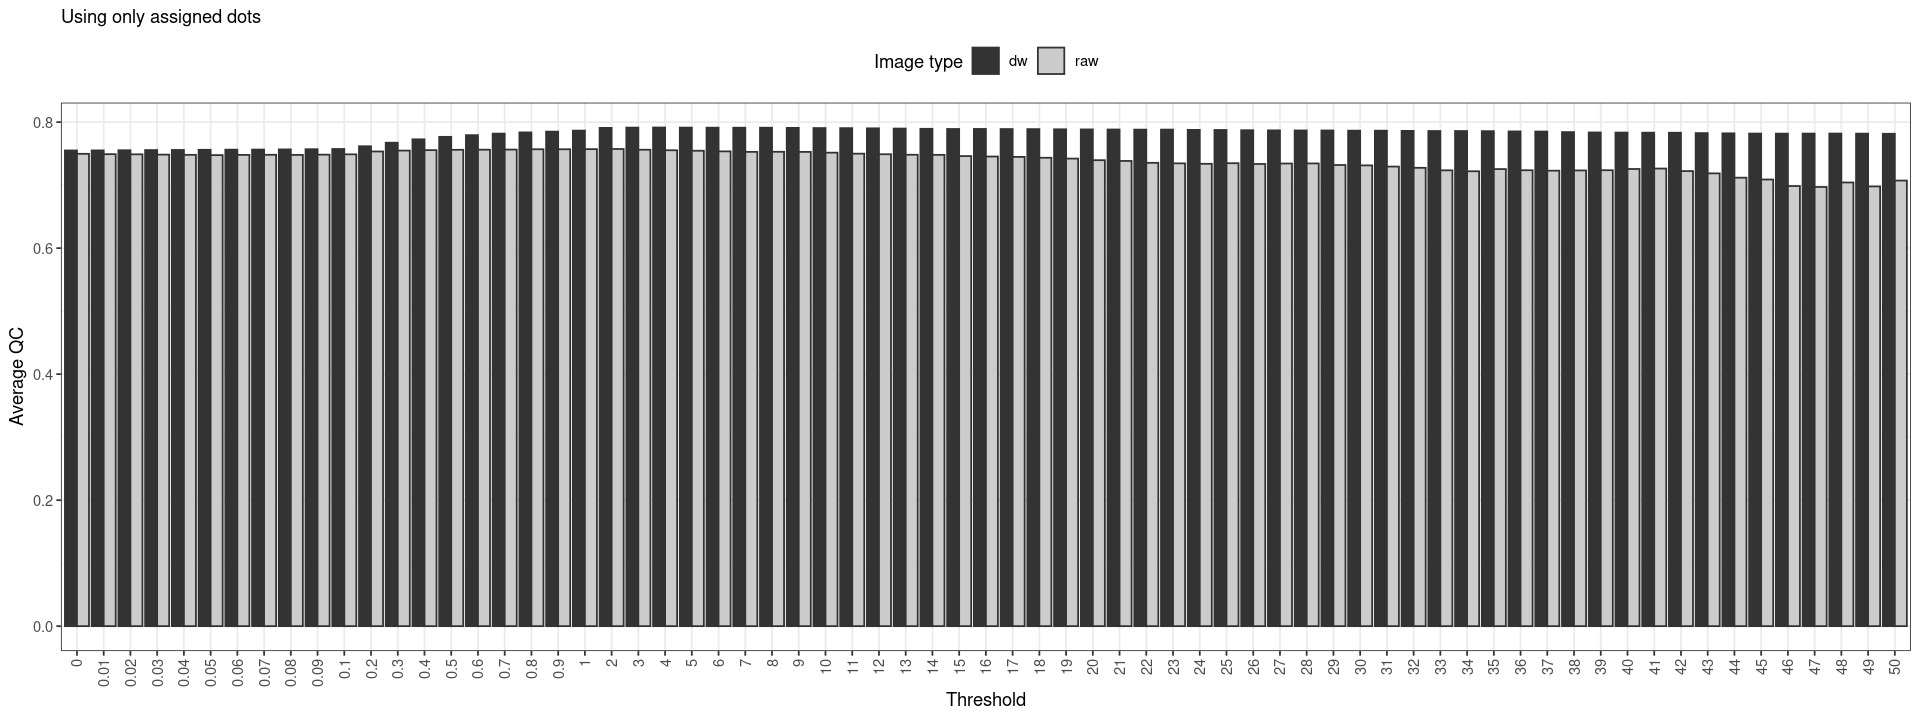

In [28]:
options(repr.plot.width=16, repr.plot.height=6)
ggplot(qc_data, aes(x=factor(thr), y=QC_mean, fill=image_type)) + geom_col(position="dodge", color="#323232") +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    labs(x="Threshold", y="Average QC", fill="Image type", subtitle="Using only assigned dots") +
    scale_fill_grey()

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


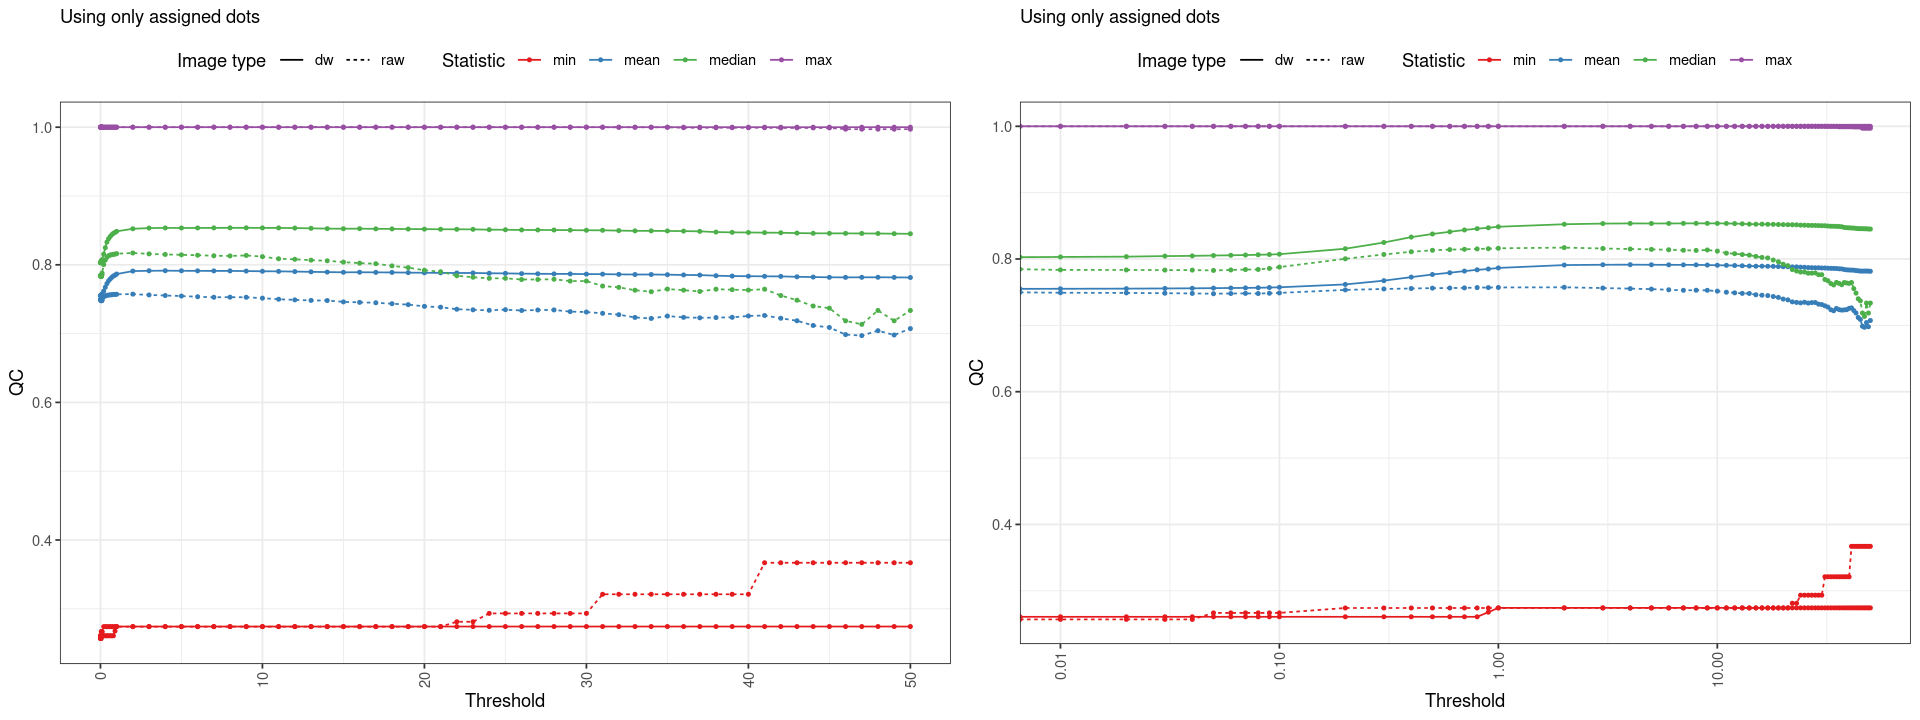

In [15]:
p1 = ggplot(pdata_qc, aes(x=thr, y=value, linetype=image_type, color=variable)) + geom_line() + geom_point(size=.75) +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    labs(x="Threshold", y="QC", linetype="Image type", subtitle="Using only assigned dots") +
    scale_color_brewer("Statistic", labels=c("min", "mean", "median", "max"), palette="Set1")
p2 = ggplot(pdata_qc, aes(x=thr, y=value, linetype=image_type, color=variable)) + geom_line() + geom_point(size=.75) +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    scale_x_log10() + labs(x="Threshold", y="QC", linetype="Image type", subtitle="Using only assigned dots") +
    scale_color_brewer("Statistic", labels=c("min", "mean", "median", "max"), palette="Set1")
options(repr.plot.width=16, repr.plot.height=6)
plot_grid(p1, p2, nrow=1)

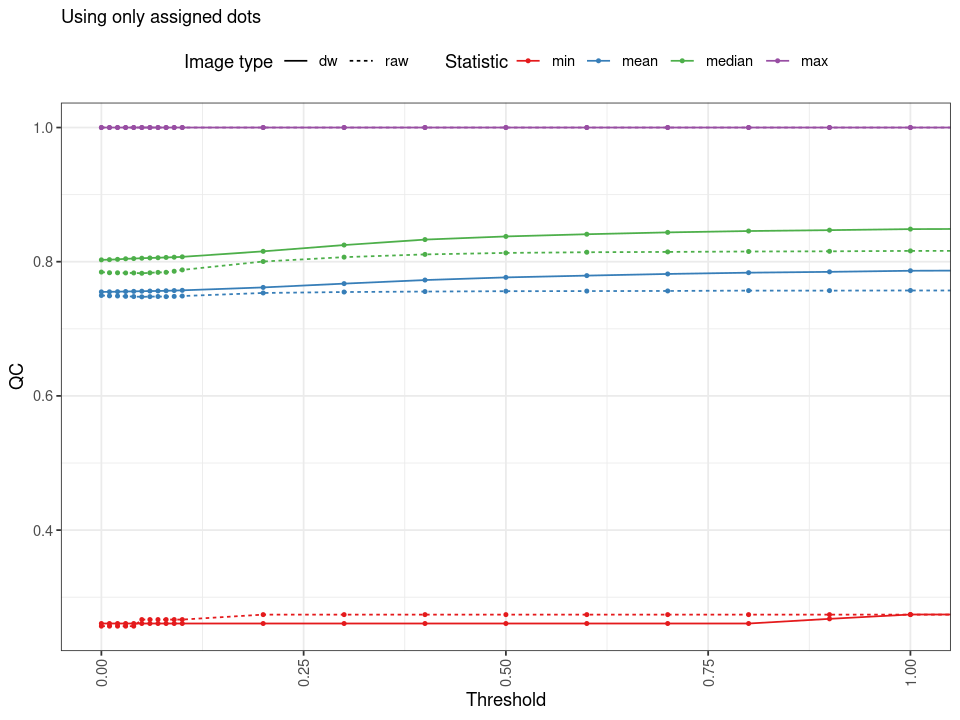

In [30]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(pdata_qc, aes(x=thr, y=value, linetype=image_type, color=variable)) + geom_line() + geom_point(size=.75) +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    labs(x="Threshold", y="QC", linetype="Image type", subtitle="Using only assigned dots") +
    scale_color_brewer("Statistic", labels=c("min", "mean", "median", "max"), palette="Set1") +
    coord_cartesian(xlim=c(0, 1))

# Quality of assigned/unassigned

# Counts and ratio of assigned and unassigned dots

In [17]:
pdata = ddata[, .N, by=c("image_type", "thr", "target_assigned")]

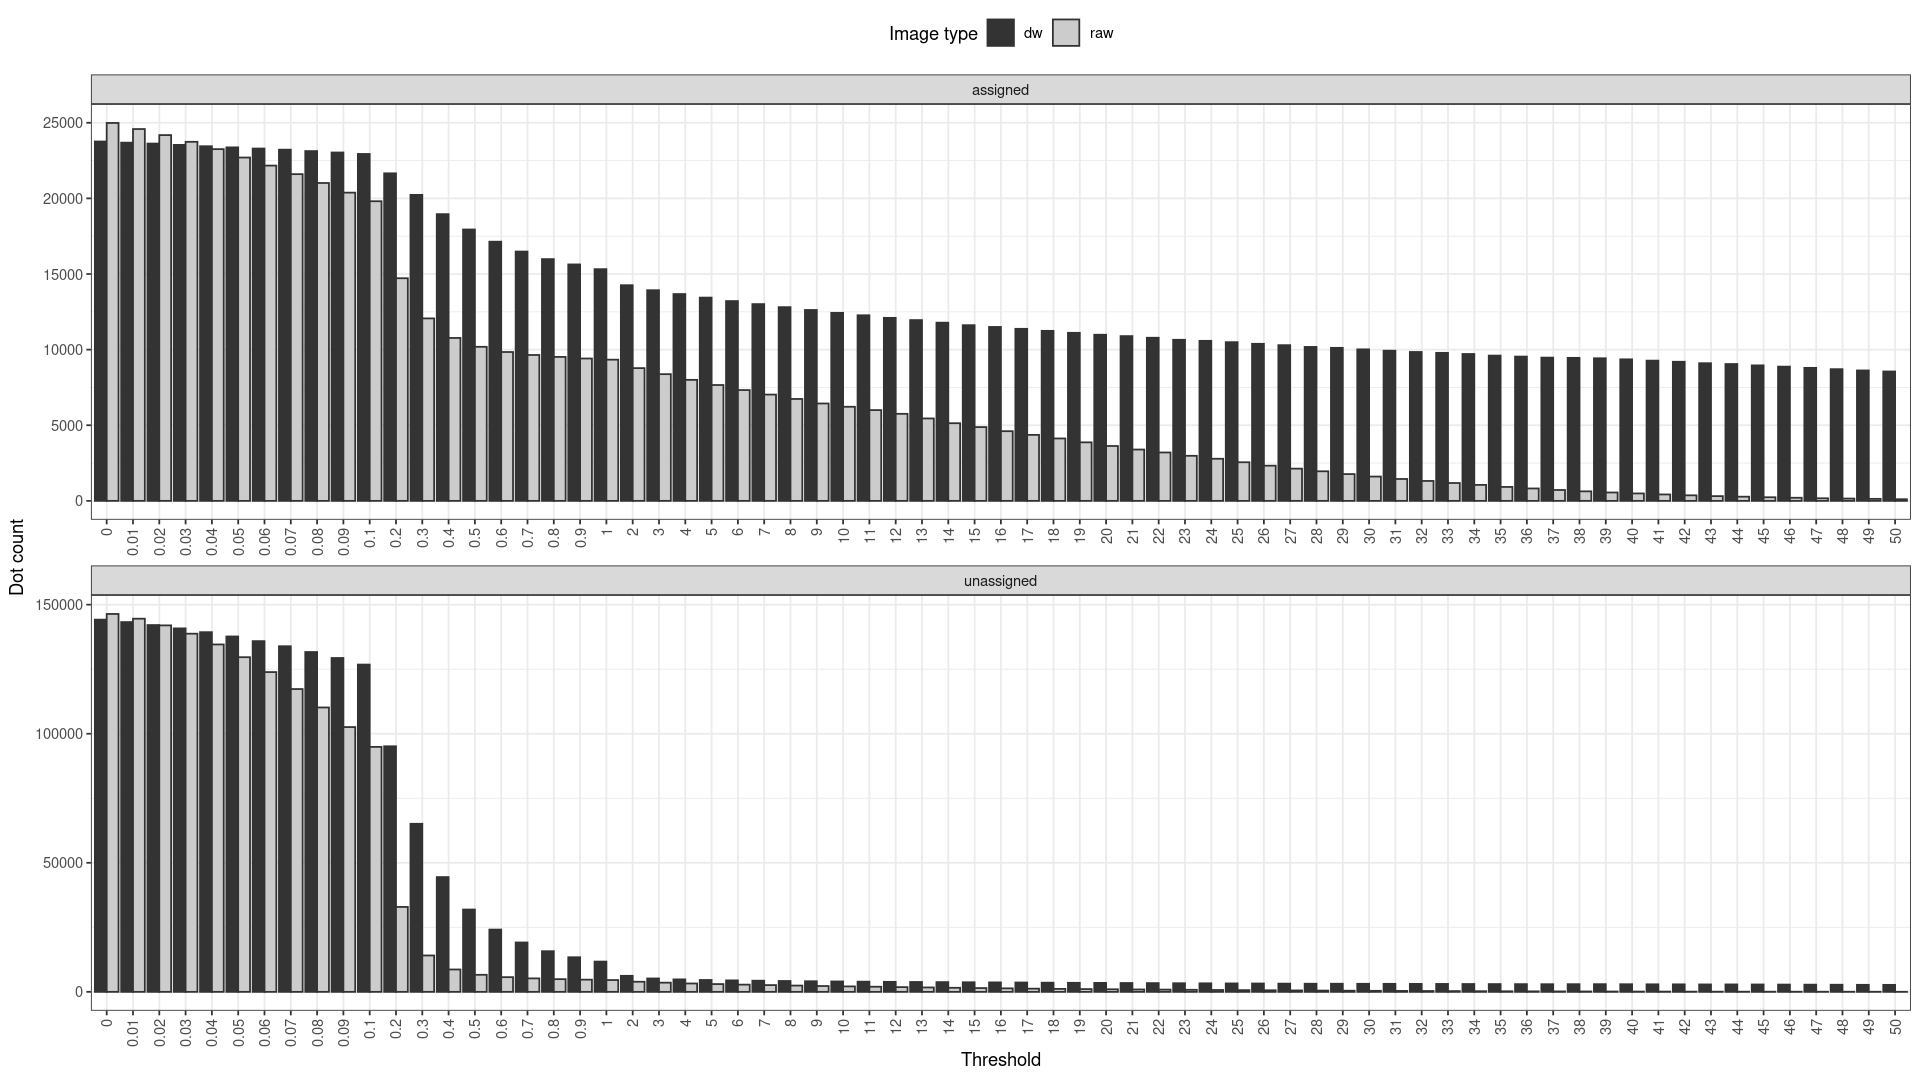

In [18]:
options(repr.plot.width=16, repr.plot.height=9)
ggplot(pdata, aes(x=factor(thr), y=N, fill=image_type)) + geom_col(position="dodge", color="#323232") +
    facet_wrap(~target_assigned, nrow=2, scales="free") + theme_bw() +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    scale_fill_grey() + labs(x="Threshold", y="Dot count", fill="Image type")

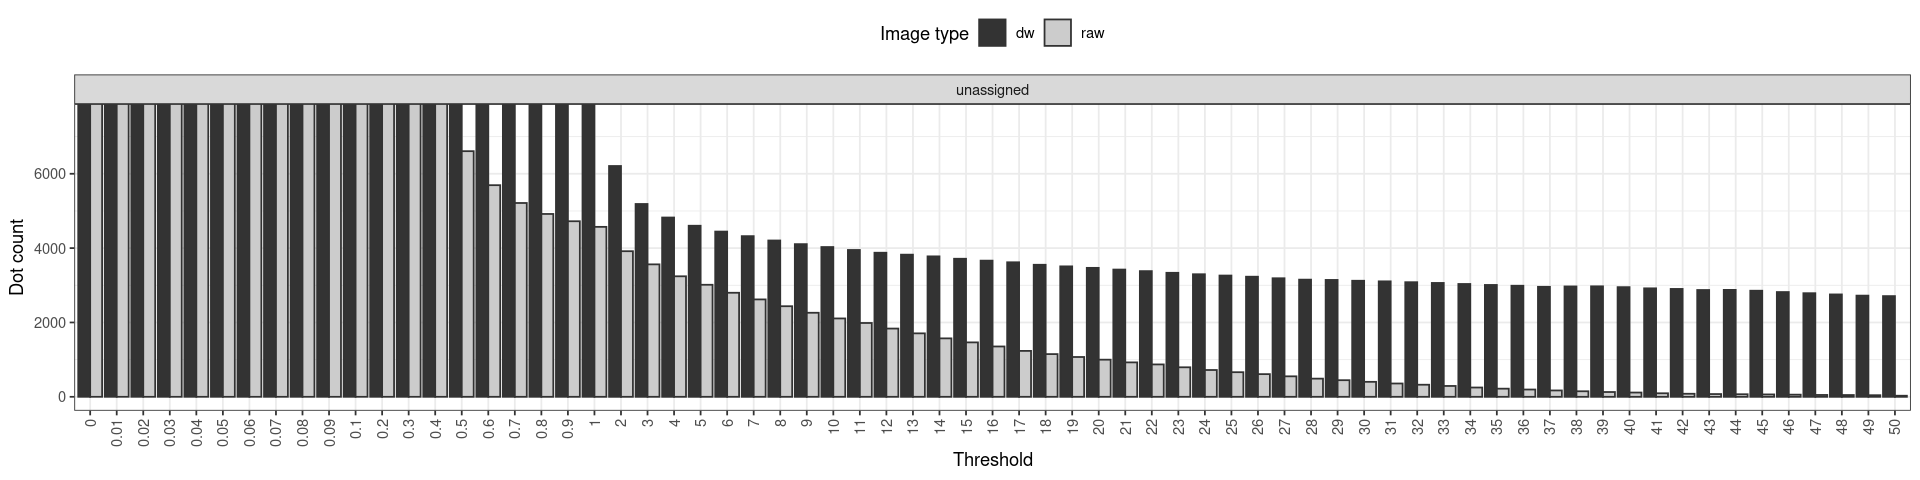

In [19]:
options(repr.plot.width=16, repr.plot.height=4)
ggplot(pdata["unassigned" == target_assigned], aes(x=factor(thr), y=N, fill=image_type)) + geom_col(position="dodge", color="#323232") +
    facet_wrap(~target_assigned, nrow=2, scales="free") + theme_bw() +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    scale_fill_grey() + labs(x="Threshold", y="Dot count", fill="Image type") +
    coord_cartesian(ylim=c(0, 7500))

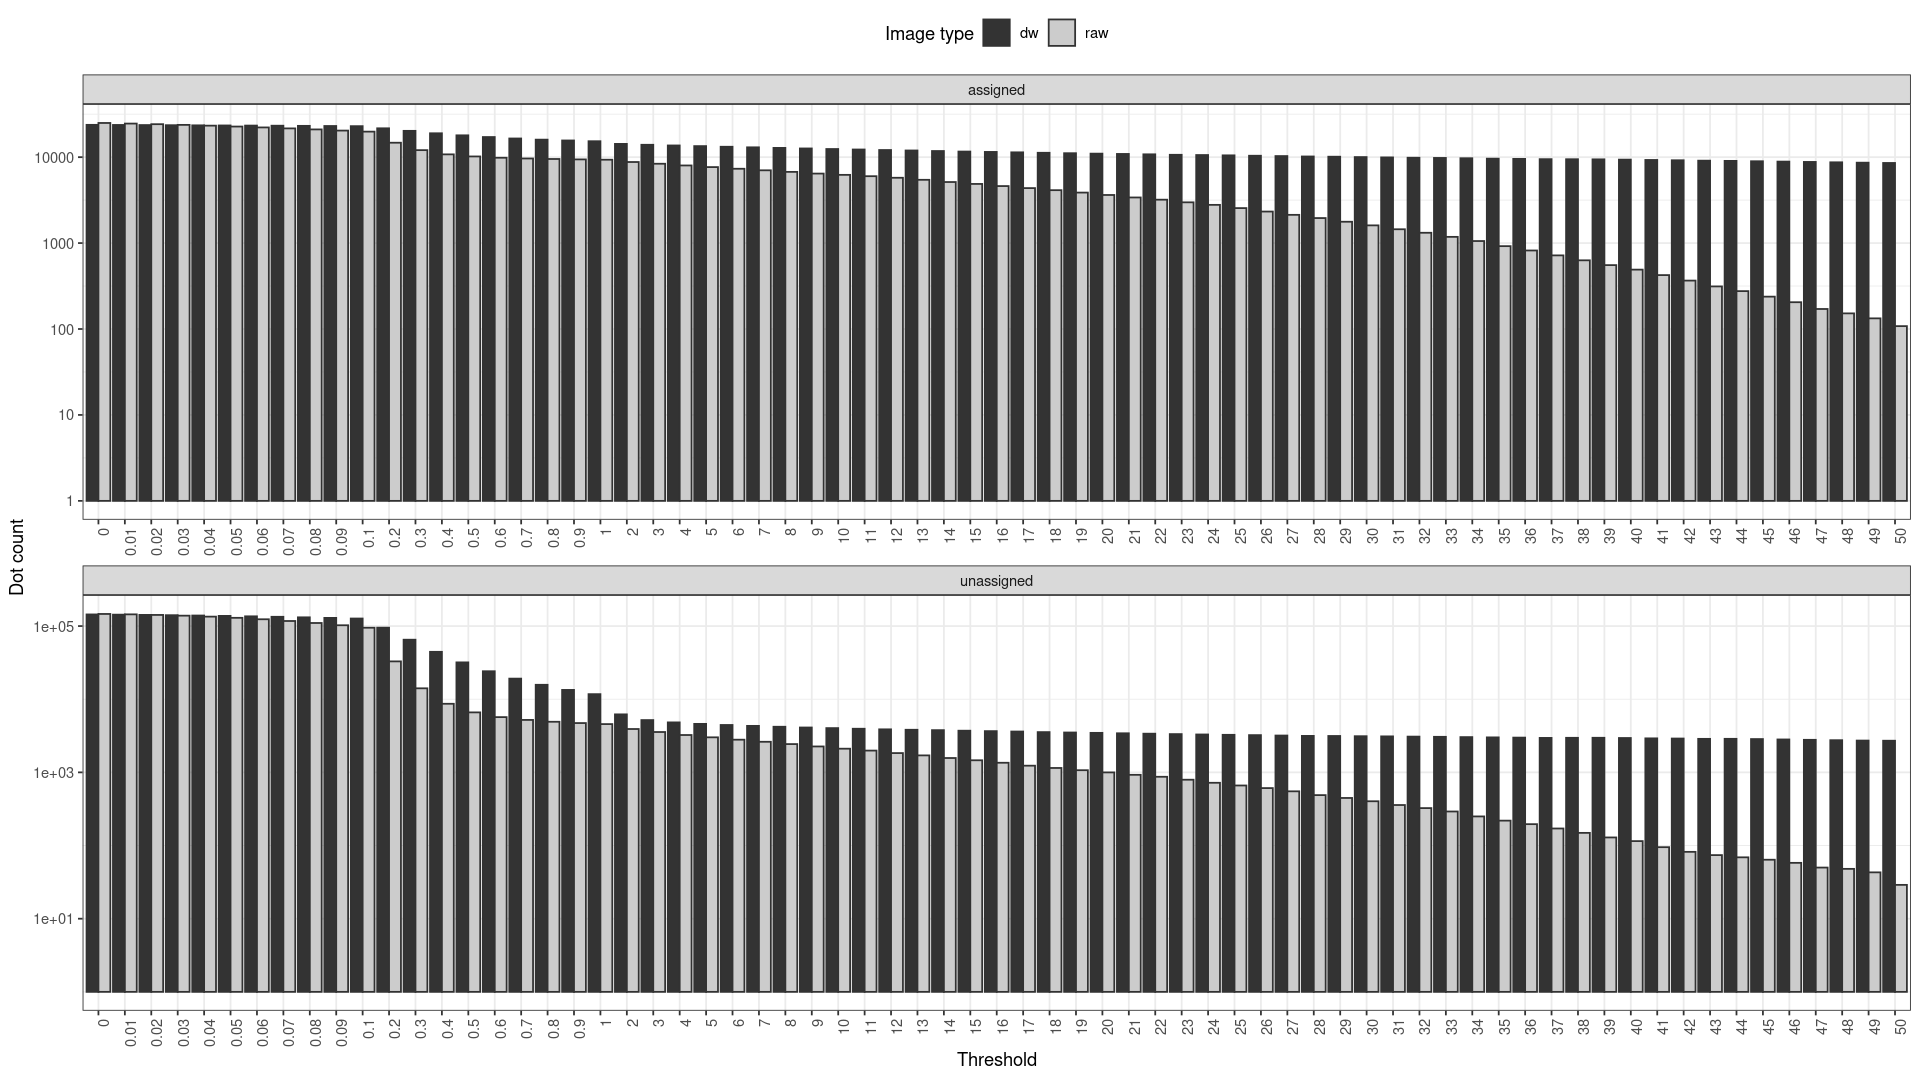

In [20]:
options(repr.plot.width=16, repr.plot.height=9)
ggplot(pdata, aes(x=factor(thr), y=N, fill=image_type)) + geom_col(position="dodge", color="#323232") +
    facet_wrap(~target_assigned, nrow=2, scales="free") + theme_bw() +
    theme(axis.text.x=element_text(angle=90, hjust=1), legend.position="top") +
    scale_fill_grey() + labs(x="Threshold", y="Dot count", fill="Image type") +
    scale_y_log10()

In [21]:
pdata2 = dcast(pdata, image_type+thr~target_assigned, value.var="N")[, .(image_type, thr, ratio_au=assigned/unassigned)]

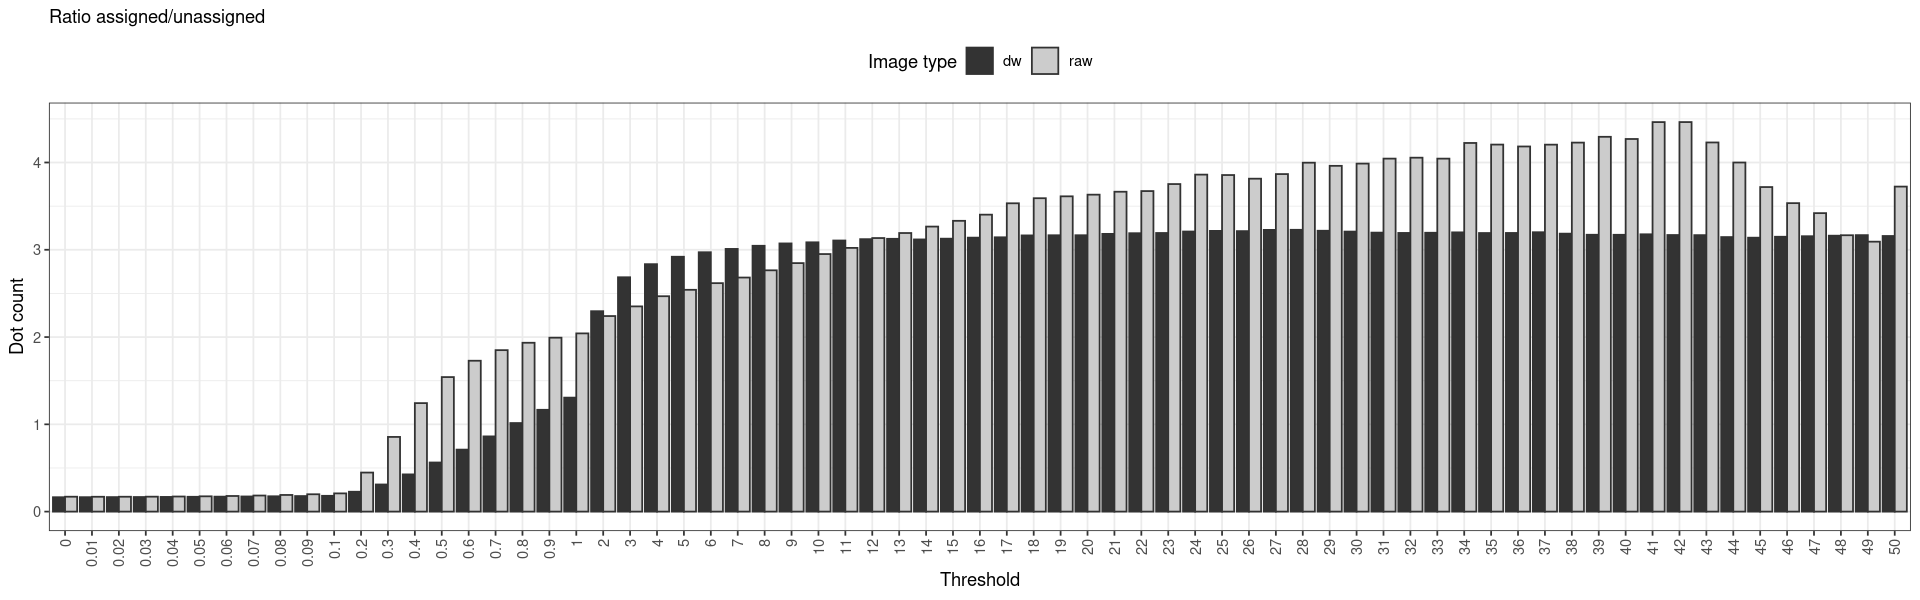

In [22]:
options(repr.plot.width=16, repr.plot.height=5)
ggplot(pdata2, aes(x=factor(thr), y=ratio_au, fill=image_type)) + geom_col(position="dodge", color="#323232") +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    scale_fill_grey() + labs(x="Threshold", y="Dot count", fill="Image type", subtitle="Ratio assigned/unassigned")

In [23]:
pdata3 = pdata[, .(N=sum(N)), by=c("image_type", "thr")]

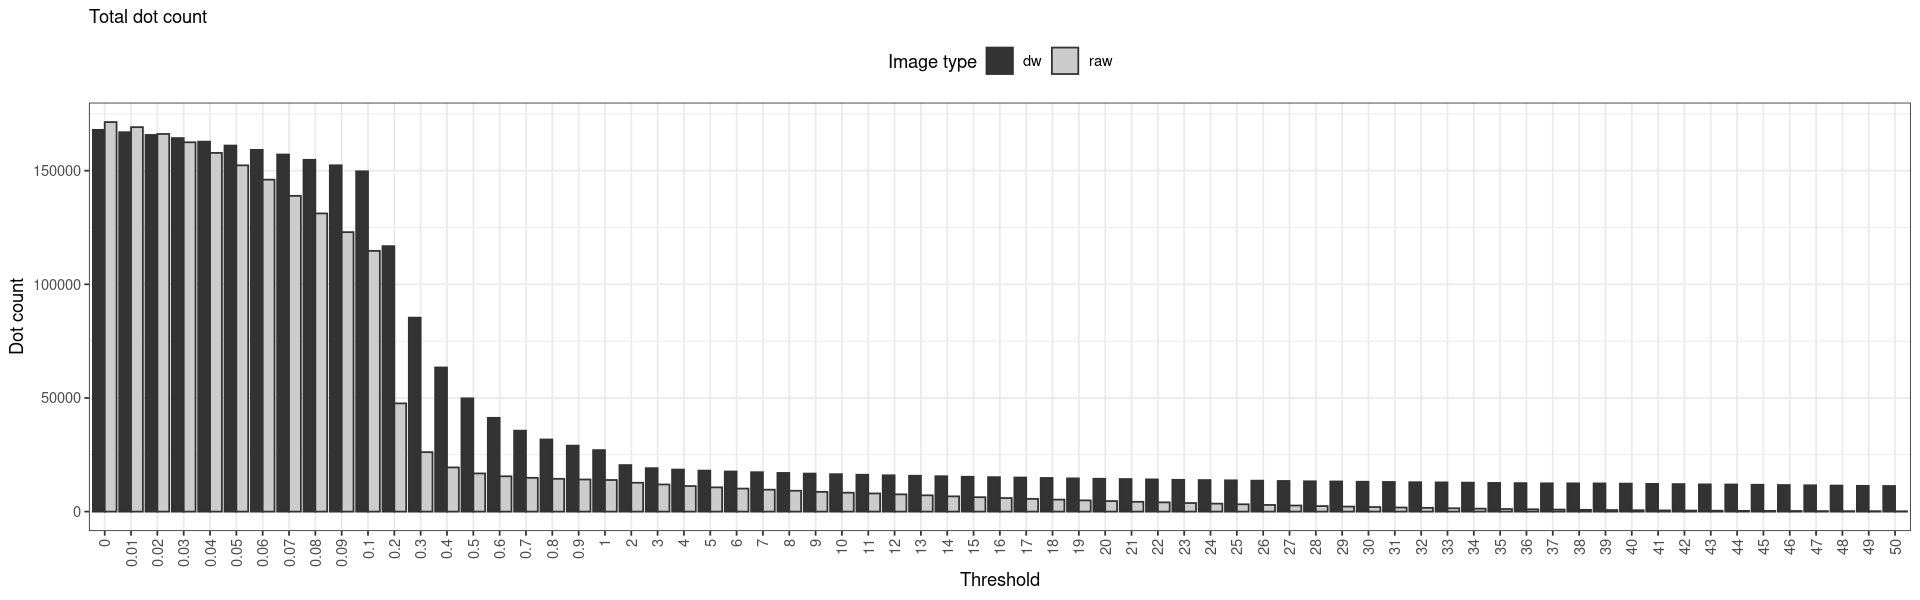

In [24]:
options(repr.plot.width=16, repr.plot.height=5)
ggplot(pdata3, aes(x=factor(thr), y=N, fill=image_type)) + geom_col(position="dodge", color="#323232") +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    scale_fill_grey() + labs(x="Threshold", y="Dot count", fill="Image type", subtitle="Total dot count")

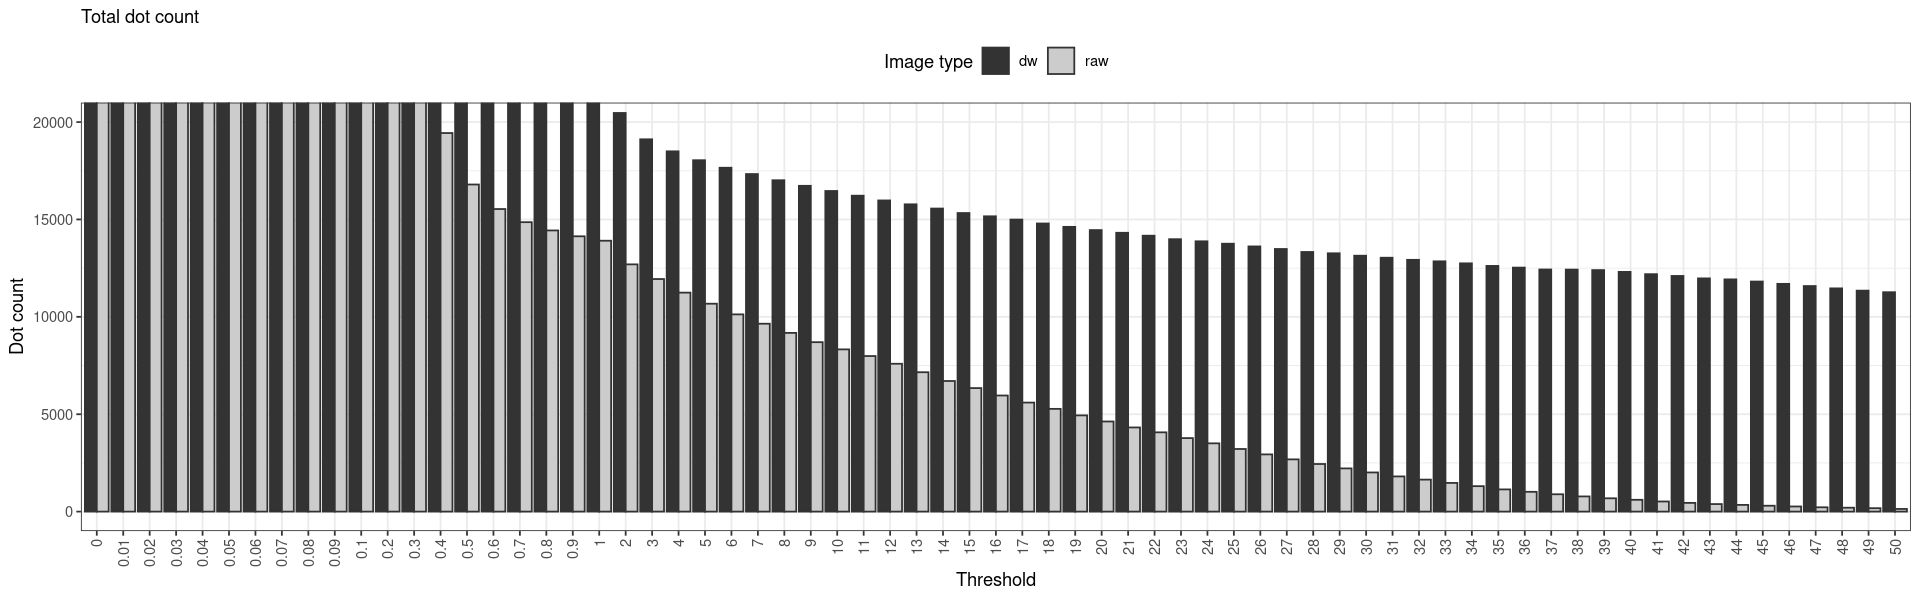

In [25]:
options(repr.plot.width=16, repr.plot.height=5)
ggplot(pdata3, aes(x=factor(thr), y=N, fill=image_type)) + geom_col(position="dodge", color="#323232") +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    scale_fill_grey() + labs(x="Threshold", y="Dot count", fill="Image type", subtitle="Total dot count") +
    coord_cartesian(ylim=c(0, 20000))

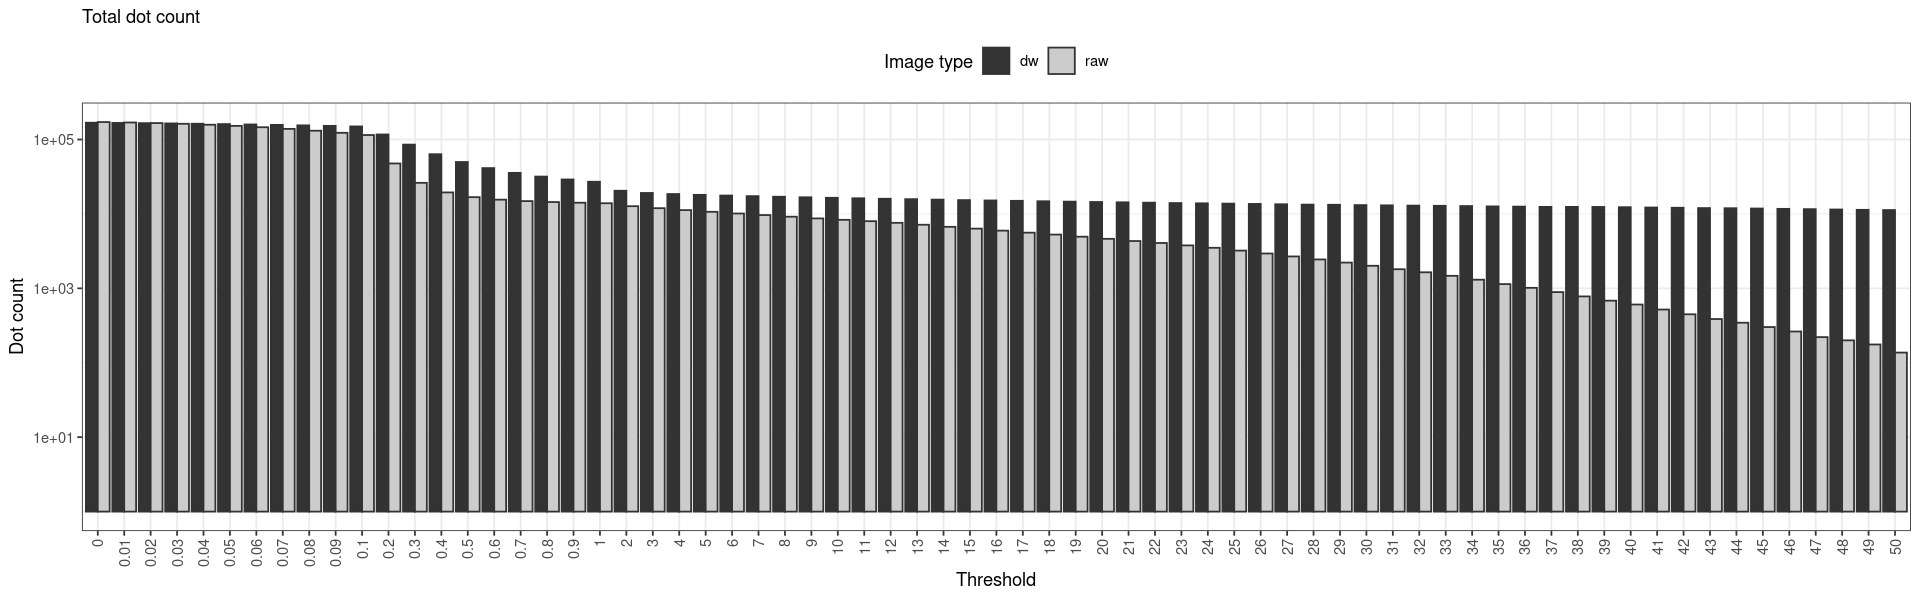

In [26]:
options(repr.plot.width=16, repr.plot.height=5)
ggplot(pdata3, aes(x=factor(thr), y=N, fill=image_type)) + geom_col(position="dodge", color="#323232") +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    scale_fill_grey() + labs(x="Threshold", y="Dot count", fill="Image type", subtitle="Total dot count") +
    scale_y_log10()